Parsing SUMO edges from test_scenarios/CheshireBridgeRd/plain.edg.xml with offset (-744573.44, -3744834.81) and CRS +proj=utm +zone=16 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


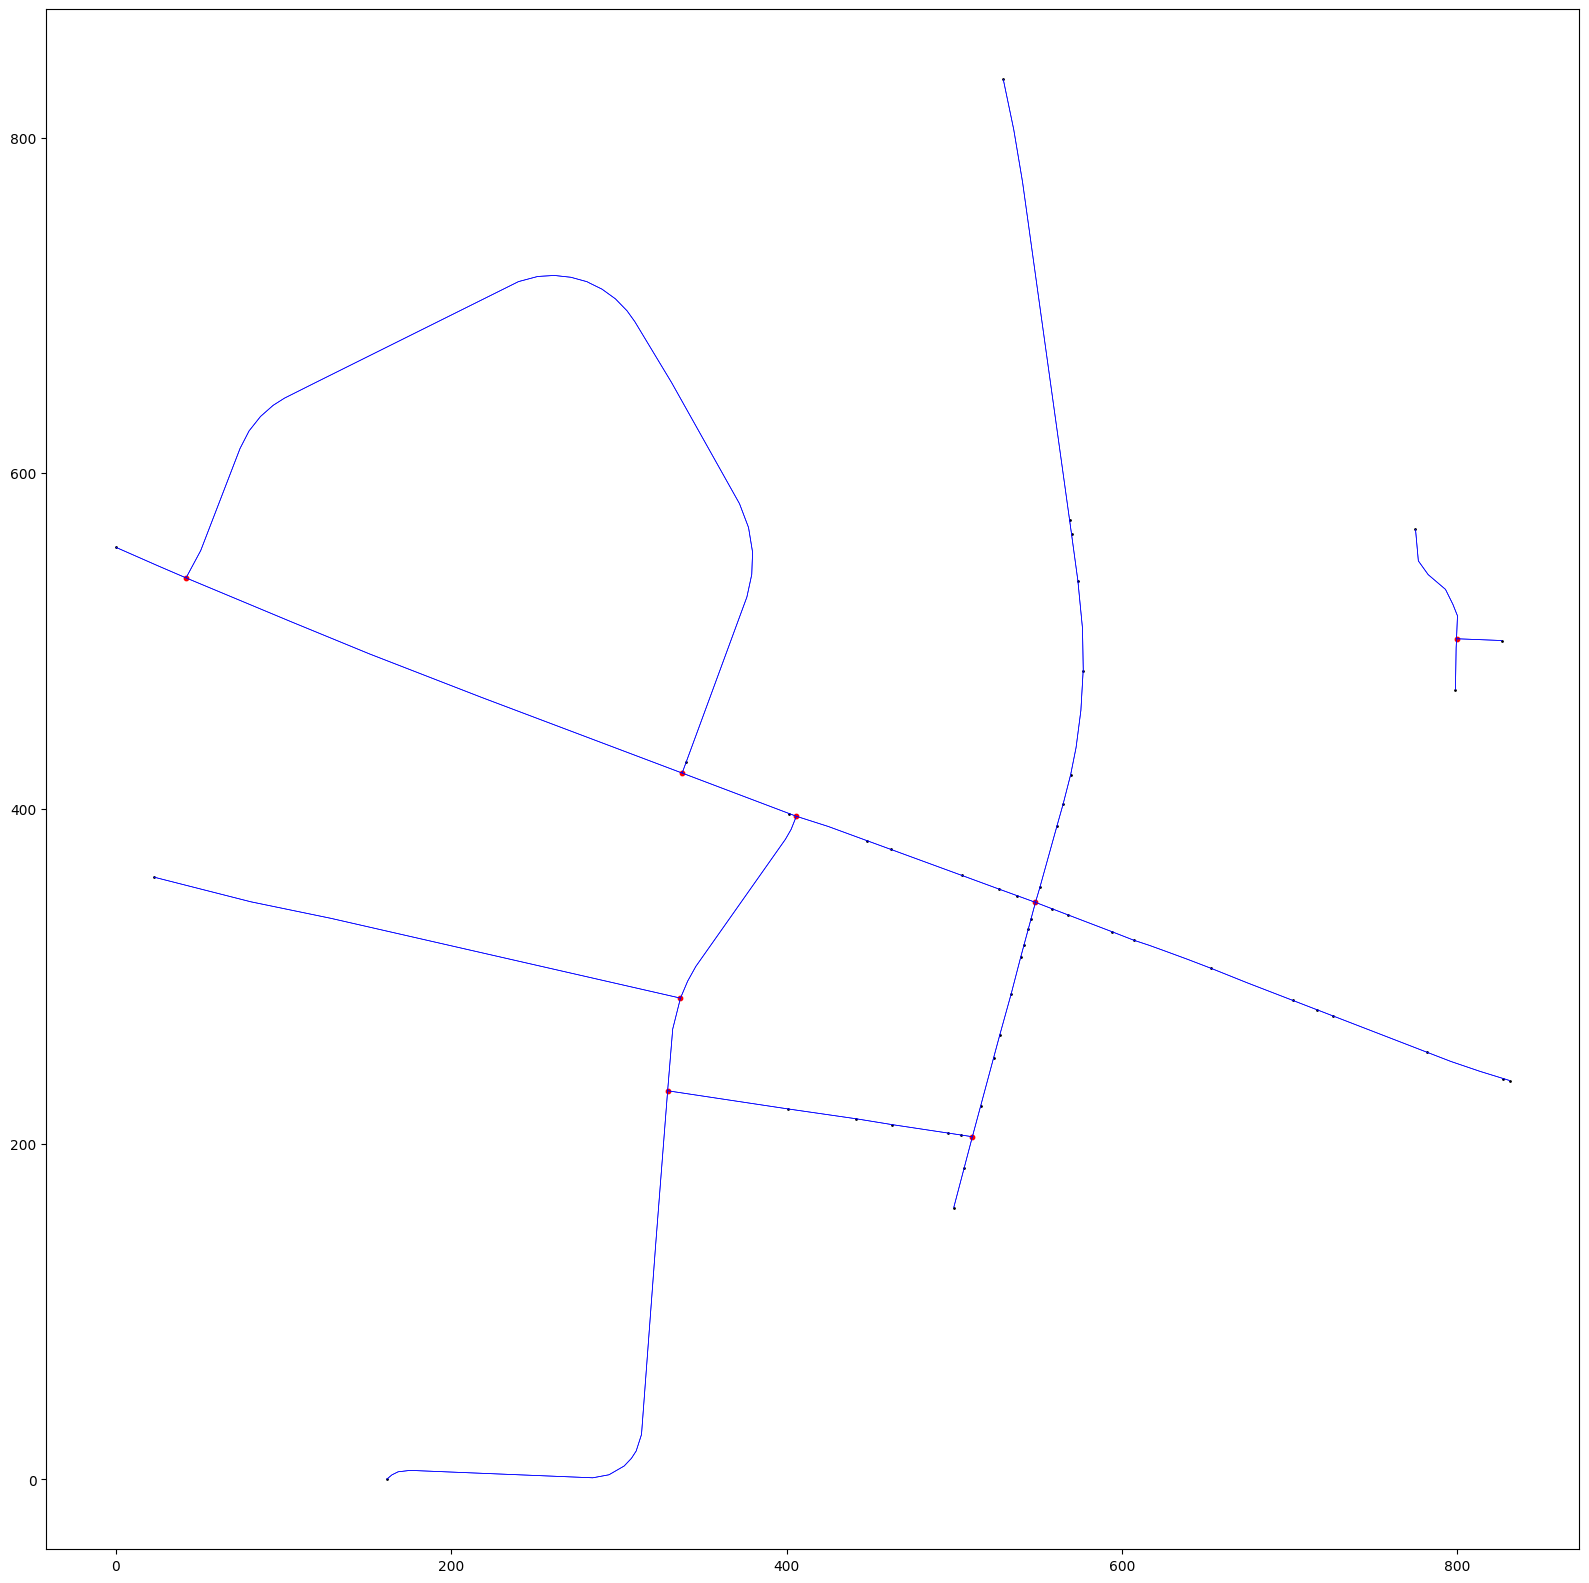

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon
from typing import Dict, Tuple, List
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.affinity import translate
from shapely.ops import substring
from utils.network_parse_utils import SUMONode, SUMOEdge, SUMOConnection, SUMOLane
from utils.network_parse_utils import parse_SUMO_edges, parse_SUMO_connections, parse_SUMO_nodes, extract_intersection_centers_from_osm

class SUMONet():

    def __init__(self, SUMO_nodes_dict: Dict[str, SUMONode], 
                 SUMO_edges_dict: Dict[str, SUMOEdge],
                 SUMO_connections_from_to_dict: Dict[str, SUMOConnection],
                 SUMO_connections_to_from_dict: Dict[str, SUMOConnection],
                 net_offset: tuple[float, float],
                 crs_proj: CRS):

        self.net_offset = net_offset
        self.crs_proj = crs_proj
        self.edges_dict = SUMO_edges_dict
        self.nodes_dict = SUMO_nodes_dict
        self.edges_gdf = SUMONet.sumo_edges_dict_to_gdf(SUMO_edges_dict, SUMO_nodes_dict, crs_proj=self.crs_proj)
        self.nodes_gdf = SUMONet.sumo_nodes_dict_to_gdf(SUMO_nodes_dict, crs_proj=self.crs_proj)
        self.connections_from_to_dict = SUMO_connections_from_to_dict
        self.connections_to_from_dict = SUMO_connections_to_from_dict
        self.new_node_cnt = 0
        self.new_edge_cnt = 0

    @staticmethod
    def sumo_edges_dict_to_gdf(SUMO_edges_dict: Dict[str, SUMOEdge], SUMO_nodes_dict: Dict[str, SUMONode], crs_proj: CRS) -> gpd.GeoDataFrame:
        features = []
        for edge in SUMO_edges_dict.values():
            geom = []
            from_node = SUMO_nodes_dict.get(edge.from_node)
            to_node = SUMO_nodes_dict.get(edge.to_node)
            edge_coordinates = edge.shape_string_to_coordinates()
            geom = [(from_node.x, from_node.y), *edge_coordinates, (to_node.x, to_node.y)]

            feature = {
                "geometry": LineString(geom),
                "id": edge.id,
                "from": edge.from_node,
                "to": edge.to_node,
                "type": edge.edge_type,
                "numLanes": edge.numLanes,
                "disallow": edge.disallow
            }
            features.append(feature)
        return gpd.GeoDataFrame(features, crs=crs_proj)

    @staticmethod
    def sumo_nodes_dict_to_gdf(SUMO_nodes_dict: Dict[str, SUMONode], crs_proj: CRS) -> gpd.GeoDataFrame:
        features = []
        for node in SUMO_nodes_dict.values():
            feature = {
                "geometry": Point(node.x, node.y),
                "id": node.id,
                "type": node.node_type
            }
            features.append(feature)
        return gpd.GeoDataFrame(features, crs=crs_proj)

    @staticmethod
    def make_sumo_converter(proj_str, net_offset):
        """
        Returns two functions: 
          sumo_xy_to_lonlat(x, y) and lonlat_to_sumo_xy(lon, lat)
        proj_str: full projParameter string from SUMO <location> tag
        net_offset: tuple (offset_x, offset_y) from SUMO <location> tag
        """
        crs_src = CRS.from_proj4(proj_str)      # source: SUMO's projected CRS
        crs_dst = CRS.from_epsg(4326)           # target: WGS84 lat/lon

        to_lonlat = Transformer.from_crs(crs_src, crs_dst, always_xy=True)
        to_proj   = Transformer.from_crs(crs_dst, crs_src, always_xy=True)

        net_offset_x, net_offset_y = net_offset

        def sumo_xy_to_lonlat(x, y):
            X_proj = x + net_offset_x
            Y_proj = y + net_offset_y
            lon, lat = to_lonlat.transform(X_proj, Y_proj)
            return lon, lat

        def lonlat_to_sumo_xy(lon, lat):
            X_proj, Y_proj = to_proj.transform(lon, lat)
            x = X_proj - net_offset_x
            y = Y_proj - net_offset_y
            return x, y

        return sumo_xy_to_lonlat, lonlat_to_sumo_xy


    def get_nodes_degree_dict(self) -> Dict[str, int]:
        in_degree_dict = {}
        out_degree_dict = {}
        for edge in self.edges_dict.values():
            out_degree_dict[edge.from_node] = out_degree_dict.get(edge.from_node, 0) + 1
            in_degree_dict[edge.to_node] = in_degree_dict.get(edge.to_node, 0) + 1
        return in_degree_dict, out_degree_dict

    def get_intersection_nodes_gdf(self) -> gpd.GeoDataFrame:
        in_degree_dict, out_degree_dict = self.get_nodes_degree_dict()
        intersection_nodes = [node_id for node_id, degree in in_degree_dict.items() if degree > 2]
        return self.nodes_gdf[self.nodes_gdf['id'].isin(intersection_nodes)]

    def remove_isolated_nodes(self):
        # Remove nodes that are not connected to any edge
        connected_nodes = set(self.edges_gdf['from']).union(set(self.edges_gdf['to']))
        self.nodes_gdf = self.nodes_gdf[self.nodes_gdf['id'].isin(connected_nodes)]
        self.nodes_dict = {k: v for k, v in self.nodes_dict.items() if k in connected_nodes}
    
    def find_intersected_edges(self, intersection_chip: Polygon) -> gpd.GeoDataFrame:
        # Find edges that intersect with the given chip
        return self.edges_gdf[self.edges_gdf.intersects(intersection_chip)]

    def find_intersected_edges_with_both_nodes_within(self, intersection_chip: Polygon) -> gpd.GeoDataFrame:
        # Find edges that have both nodes within the given chip
        intersected_edges = self.edges_gdf[self.edges_gdf.intersects(intersection_chip)]
        nodes_within = self.nodes_gdf[self.nodes_gdf.within(intersection_chip)]
        return intersected_edges[intersected_edges['from'].isin(nodes_within['id']) & intersected_edges['to'].isin(nodes_within['id'])]

    def find_nodes_within(self, intersection_chip: Polygon) -> gpd.GeoDataFrame:
        # Find nodes that are within the given chip
        return self.nodes_gdf[self.nodes_gdf.within(intersection_chip)]

    def build_intersection_chip(self, x, y, width, height):
        # the x y coresponds to the center of the chip in sumo cooridnate
        # the height and width are in the meters
        # this function returns the shape of the resutling chip (Polygon)

        chip = Polygon([
            (x - width / 2, y - height / 2),
            (x + width / 2, y - height / 2),
            (x + width / 2, y + height / 2),
            (x - width / 2, y + height / 2)
        ])

        return chip

    def add_nodes_to_edges_at_intersected_points(self, intersection_center: Tuple[float, float]) -> None:
        intersection_center_x, intersection_center_y = intersection_center
        intersection_center_point = Point(intersection_center_x, intersection_center_y)
        # add the intersection center to the nodes gdf and nodes dict
        intersection_node = SUMONode(id=f"N_new_{self.new_node_cnt}", x=intersection_center_x, y=intersection_center_y, node_type="traffic_light")
        self.nodes_gdf = pd.concat([self.nodes_gdf, pd.DataFrame([{'id': intersection_node.id, 'type': intersection_node.node_type, 'geometry': intersection_center_point}])], ignore_index=True)
        self.nodes_dict[intersection_node.id] = intersection_node
        self.new_node_cnt += 1

        chip = self.build_intersection_chip(intersection_center_x, intersection_center_y, 80, 80)
        # Find all intersected edges
        intersected_edges = self.find_intersected_edges(chip)
        # Find all intersected edges with both nodes within the chip
        intersected_edges_with_both_nodes = self.find_intersected_edges_with_both_nodes_within(chip)
        # Since we only care the edges that go through the chip, we may call it key edges here
        key_edges = intersected_edges[~intersected_edges['id'].isin(intersected_edges_with_both_nodes['id'])]
        
        nodes_within_chip = self.find_nodes_within(chip)

        # The candidate edges can be viewed as edges that crossing the chip, and with one node added at the intersecting point, the other end is calculated based on the reference line
        candidate_edge_gdf = gpd.GeoDataFrame(columns=['from_node', 'to_node', 'old_edge_id', 'should_connect_from_new_edge_to_old_edge'])
        for edge_id in key_edges['id'].unique():
            edge = key_edges.loc[key_edges['id'] == edge_id].iloc[0]
            edge_geom = edge.geometry

            # Find intersection points
            intersected_point = edge_geom.intersection(chip.boundary)
            # if the intersected point is empty or more than one point is found, raise error
            if intersected_point.is_empty:
                raise ValueError(f"No intersection point found for edge {edge_id}")
            elif intersected_point.geom_type == 'MultiPoint':
                # if multiple points are found, take the closest one to the edge's centroid
                edge_centroid = edge_geom.centroid
                intersected_point = min(intersected_point.geoms, key=lambda p: p.distance(edge_centroid))
            elif intersected_point.geom_type != 'Point':
                raise ValueError(f"Invalid intersection geometry for edge {edge_id}: {intersected_point.geom_type}")
            else:
                intersected_point = intersected_point.centroid
            # the edge should be splited, adding the new node
            # the candidate node pair are whose geometery and num of lanes should be determined through the lane extraction model
            candicate_edge_nodes_pair, old_edge_id, should_connect_from_new_edge_to_old_edge = self.split_edge_at_point(edge_id, 
                                                                                                                        intersected_point,
                                                                                                                        intersection_node,
                                                                                                                        nodes_within_chip)
            from_node, to_node = candicate_edge_nodes_pair
            print(candicate_edge_nodes_pair)
            new_row = gpd.GeoDataFrame({
                'edge_id': f"E_new_{self.new_edge_cnt}",
                'from_node': from_node,
                'to_node': to_node,
                'old_edge_id': old_edge_id,
                'should_connect_from_new_edge_to_old_edge': should_connect_from_new_edge_to_old_edge,
                'geometry': LineString([self.nodes_gdf.loc[self.nodes_gdf["id"] == from_node, "geometry"].values[0],
                                self.nodes_gdf.loc[self.nodes_gdf["id"] == to_node, "geometry"].values[0]])
            }, index=[0], crs=self.edges_gdf.crs, geometry='geometry')
            self.new_edge_cnt += 1
            candidate_edge_gdf = pd.concat([candidate_edge_gdf, new_row], ignore_index=True)
        
        candidate_edge_gdf.set_geometry('geometry', inplace=True)
        candidate_edge_gdf.crs = self.edges_gdf.crs
        # also we want remove the edges that both nodes are within the chip
        self.edges_gdf = self.edges_gdf[~self.edges_gdf['id'].isin(intersected_edges_with_both_nodes['id'])]
        # also we need to remove the coresponding connections
        self.connections_from_to_dict = {k: v for k, v in self.connections_from_to_dict.items() if k not in intersected_edges_with_both_nodes['id']}
        self.connections_to_from_dict = {k: v for k, v in self.connections_to_from_dict.items() if k not in intersected_edges_with_both_nodes['id']}
        # also if a node is not connected to any edge, then the node should be removed
        
        

        gdf_lanes = gpd.read_parquet("lanes.parquet")

        referenc_lines = {}
        offset = (515, 310)
         # this should be modfied, the offset should be directly from the SUMO network
        # thie is the offset between sumo coodinate and the local coodinate of the XODR
        for road_id, group in gdf_lanes.groupby('road_id'):
            row = group.iloc[0]
            referenc_lines[road_id] = row['reference_geom']
            # add offset to reference line
            referenc_lines[road_id] = translate(referenc_lines[road_id], xoff=offset[0], yoff=offset[1])

        for edge_id, group_edge in candidate_edge_gdf.groupby('edge_id'):
            row = group_edge.iloc[0]
            edge_geom = row['geometry']
            # find the closest reference line
            closest_road_id = None
            closest_distance = float('inf')
            for road_id, ref_line in referenc_lines.items():
                distance = edge_geom.hausdorff_distance(ref_line)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_road_id = road_id
            # assign back the road id
            candidate_edge_gdf.loc[candidate_edge_gdf['edge_id'] == edge_id, 'road_id'] = closest_road_id
            print(f"Edge {edge_id} closest to road {closest_road_id} at distance {closest_distance:.3g}")

        for edge_id, group_edge in candidate_edge_gdf.groupby('edge_id'):
            edge_geom = group_edge.iloc[0].geometry
            closest_road_id = group_edge.iloc[0].road_id  # already assigned above
            ref_line = referenc_lines[closest_road_id]

            # compute orientation
            edge_start, edge_end = edge_geom.coords[0], edge_geom.coords[-1]
            ref_start, ref_end = ref_line.coords[0], ref_line.coords[-1]
            edge_vec = (edge_end[0]-edge_start[0], edge_end[1]-edge_start[1])
            ref_vec = (ref_end[0]-ref_start[0], ref_end[1]-ref_start[1])
            dot_product = edge_vec[0]*ref_vec[0] + edge_vec[1]*ref_vec[1]
            side = "right" if dot_product > 0 else "left"

            related_lanes = gdf_lanes[(gdf_lanes['road_id']==closest_road_id) &
                                      (gdf_lanes['lane_side']==side)]

            if related_lanes.empty:
                print(f"⚠️ Edge {edge_id}: no {side}-side lanes found on road {closest_road_id}")
                continue
            
            # assign edge_id and lane indices
            gdf_lanes.loc[related_lanes.index, 'edge_id'] = edge_id
            gdf_lanes.loc[related_lanes.index, 'sumo_lane_index'] = (
                related_lanes['avg_offset'].abs().rank(method='first').astype(int) - 1
            )
            print(f"Edge {edge_id} assigned to {len(related_lanes)} {side}-side lanes")

        gdf_links = gpd.read_parquet("links.parquet")
        # then according to the gdf links, the SUMO connection of the new lanes should be established
        for link_idx, link_row in gdf_links.iterrows():
            from_fid = link_row['from_fid']
            to_fid = link_row['to_fid']
            from_lane = gdf_lanes[gdf_lanes['fid'] == from_fid]
            to_lane = gdf_lanes[gdf_lanes['fid'] == to_fid]
            from_edge_id = from_lane['edge_id'].values[0] if not from_lane.empty else None
            to_edge_id = to_lane['edge_id'].values[0] if not to_lane.empty else None
            from_lane_index = from_lane['sumo_lane_index'].values[0] if not from_lane.empty else None
            to_lane_index = to_lane['sumo_lane_index'].values[0] if not to_lane.empty else None
            connection = SUMOConnection(
                from_edge=from_edge_id,
                to_edge=to_edge_id,
                from_lane=from_lane_index,
                to_lane=to_lane_index
            )
            self.connections_from_to_dict[connection.from_edge] = connection
            self.connections_to_from_dict[connection.to_edge] = connection
            
        # Add the candidate edge to the sumo network
        for edge_idx, edge_row in candidate_edge_gdf.iterrows():
            should_connect_from_new_edge_to_old_edge = edge_row['should_connect_from_new_edge_to_old_edge']
            from_node_id = edge_row['from_node']
            to_node_id = edge_row['to_node']
            
            road_id = edge_row['road_id']
            ori_edge_geometry = edge_row['geometry']

            reference_line = referenc_lines[road_id]
            
            # Calculate the dot product to determine the direction
            edge_vector = (ori_edge_geometry.coords[-1][0] - ori_edge_geometry.coords[0][0],
                           ori_edge_geometry.coords[-1][1] - ori_edge_geometry.coords[0][1])
            reference_vector = (reference_line.coords[-1][0] - reference_line.coords[0][0],
                                reference_line.coords[-1][1] - reference_line.coords[0][1])
            dot_product = edge_vector[0] * reference_vector[0] + edge_vector[1] * reference_vector[1]

            # Determine if the edge is along or opposite the reference line
            opposite_along_reference_line = dot_product < 0

            from_node_point = self.nodes_gdf.loc[self.nodes_gdf['id'] == from_node_id, 'geometry'].values[0]
            to_node_point = self.nodes_gdf.loc[self.nodes_gdf['id'] == to_node_id, 'geometry'].values[0]
            

            # depends on the direction, one of the nodes position should be updated with the reference lines end points
            if should_connect_from_new_edge_to_old_edge:
                ori_geometry = self.nodes_gdf.loc[self.nodes_gdf['id'] == from_node_id, 'geometry'].values[0]
                if opposite_along_reference_line:
                    # road length, distance between from node and to node
                    new_from_node_point = Point(reference_line.coords[-1])
                    road_length = new_from_node_point.distance(to_node_point)
                    # cut the original edge geometry with road length
                    new_edge_geometry = substring(ori_edge_geometry, ori_edge_geometry.length-road_length, ori_edge_geometry.length)
                else:
                    new_from_node_point = Point(reference_line.coords[0])
                    road_length = new_from_node_point.distance(to_node_point)
                    new_edge_geometry = substring(ori_edge_geometry, ori_edge_geometry.length-road_length, ori_edge_geometry.length)
                    
            else:
                ori_geometry = self.nodes_gdf.loc[self.nodes_gdf['id'] == to_node_id, 'geometry'].values[0]
                if opposite_along_reference_line:
                    new_to_node_point = Point(reference_line.coords[0])
                    road_length = from_node_point.distance(new_to_node_point)
                    new_edge_geometry = substring(ori_edge_geometry, 0, road_length)
                else:
                    new_to_node_point = Point(reference_line.coords[-1])
                    road_length = from_node_point.distance(new_to_node_point)
                    new_edge_geometry = substring(ori_edge_geometry, 0, road_length)
            print(f"road length: {new_edge_geometry.length}, original length: {ori_edge_geometry.length}")

            related_lanes = gdf_lanes[gdf_lanes['edge_id'] == edge_row['edge_id']]
            lanes_dict = {}
            for lanes_idx, lanes_row in related_lanes.iterrows():
                lane_index = str(int(lanes_row['sumo_lane_index']))
                lane = SUMOLane(
                    index=lane_index,
                )
                lanes_dict[lane_index] = lane

            edge = SUMOEdge(
                id=edge_row['edge_id'],
                from_node=from_node_id,
                to_node=to_node_id,
                numLanes=len(related_lanes),
                shape="",
                disallow=None,
                allow=None
            )
            edge.coordinates_to_shape_string(list(new_edge_geometry.coords))
            edge.lanes.update(lanes_dict)
            self.edges_gdf = pd.concat([self.edges_gdf, gpd.GeoDataFrame({
                "geometry": new_edge_geometry,
                "id": edge.id,
                "from": edge.from_node,
                "to": edge.to_node,
                "type": edge.edge_type,
                "numLanes": edge.numLanes,
                "disallow": edge.disallow
            }, index=[0], crs=self.edges_gdf.crs)], ignore_index=True)
            # print(self.edges_gdf[self.edges_gdf['id'] == edge.id])
            self.edges_dict[edge.id] = edge

        print("Edges processed:", len(self.edges_dict))
        self.edges_dict = {k: v for k, v in self.edges_dict.items() if k in self.edges_gdf['id'].values}
        print("Edges retained:", len(self.edges_dict))
        self.remove_isolated_nodes()

    def split_edge_at_point(self, edge_id: str, 
                            intersected_point: Point, 
                            intersection_node: SUMONode, # center of the intersection
                            nodes_within: gpd.GeoDataFrame,
                            new_node_distance_threshold: float = 2.0):

        row = self.edges_gdf.loc[self.edges_gdf["id"] == edge_id].iloc[0]

        
        # if there is existing node in the nodes_gdf within the distance threshold, not creating the new node but use the closest one
        existing_nodes = self.nodes_gdf[self.nodes_gdf.geometry.distance(intersected_point) < new_node_distance_threshold]
        if not existing_nodes.empty:
            closest_node = existing_nodes.loc[existing_nodes.geometry.distance(intersected_point).idxmin()]
            new_node_id = closest_node['id']
        else:
            # create node for the intersected point
            new_node_id = f"N_new_{self.new_node_cnt}"
            print(intersected_point)
            print(type(intersected_point))
            new_node = gpd.GeoDataFrame(
                [{"id": new_node_id, "geometry": intersected_point}],
                geometry="geometry", crs=self.nodes_gdf.crs
            )
            
            self.nodes_gdf = pd.concat([self.nodes_gdf, new_node], ignore_index=True)
            self.nodes_dict[new_node_id] = SUMONode(id=new_node_id, x=intersected_point.x, y=intersected_point.y)
            self.new_node_cnt += 1


        candicate_edge_nodes_pair = ("", "")

        should_connect_from_new_edge_to_old_edge = False
        if row["from"] in nodes_within['id'].values:
            from_node = new_node_id
            to_node = row["to"]
            candicate_edge_nodes_pair = (intersection_node.id, new_node_id)
            should_connect_from_new_edge_to_old_edge = True
        else:
            from_node = row["from"]
            to_node = new_node_id
            candicate_edge_nodes_pair = (new_node_id, intersection_node.id)
            should_connect_from_new_edge_to_old_edge = False
        # generate geometry based on from and to node
        geometry = LineString([self.nodes_gdf.loc[self.nodes_gdf["id"] == from_node, "geometry"].values[0],
                                self.nodes_gdf.loc[self.nodes_gdf["id"] == to_node, "geometry"].values[0]])

        # 5) build two new edges (keep attrs you care about)
        base = {k: row[k] for k in row.index if k not in ["id", "from", "to", "geometry"]}
        # only Keep the non-entering intersection part
        updated_edge_row = gpd.GeoDataFrame({"id": edge_id, "from": from_node, "to": to_node, **base, "geometry": geometry}, 
                                            geometry="geometry", 
                                            crs=self.edges_gdf.crs,
                                            index=[0])
        self.edges_gdf = self.edges_gdf[self.edges_gdf["id"] != edge_id]
        # the related connections should be removed
        self.connections_from_to_dict.pop(edge_id, None)
        self.connections_to_from_dict.pop(edge_id, None)
        self.edges_gdf = pd.concat([self.edges_gdf, updated_edge_row], ignore_index=True)
        self.edges_dict[edge_id].from_node = from_node
        self.edges_dict[edge_id].to_node = to_node
        coordinates = [(float(pt[0]), float(pt[1])) for pt in geometry.coords]
        self.edges_dict[edge_id].coordinates_to_shape_string(coordinates)
        return candicate_edge_nodes_pair, edge_id, should_connect_from_new_edge_to_old_edge

        
SUMO_nodes_path = "test_scenarios/CheshireBridgeRd/plain.nod.xml"
SUMO_edges_path = "test_scenarios/CheshireBridgeRd/plain.edg.xml"
SUMO_connections_path = "test_scenarios/CheshireBridgeRd/plain.con.xml"
# osm_path = "test_scenarios/CheshireBridgeRd/CheshireBridgeRd.osm"
SUMO_nodes_dict, net_offset, crs_proj = parse_SUMO_nodes(SUMO_nodes_path)
SUMO_edges_dict, net_offset, crs_proj = parse_SUMO_edges(SUMO_edges_path)
SUMO_connections_from_to_dict, SUMO_connections_to_from_dict = parse_SUMO_connections(SUMO_connections_path)

sumo_net = SUMONet(SUMO_nodes_dict, 
                   SUMO_edges_dict,
                   SUMO_connections_from_to_dict=SUMO_connections_from_to_dict,
                   SUMO_connections_to_from_dict=SUMO_connections_to_from_dict,
                   net_offset=net_offset,
                   crs_proj=crs_proj)

get_intersection_nodes_gdf = sumo_net.get_intersection_nodes_gdf()

fig, ax = plt.subplots(figsize=(20, 20))
sumo_net.edges_gdf.plot(ax=ax, color='blue', linewidth=0.5)
sumo_net.nodes_gdf.plot(ax=ax, color='black', markersize=1)
get_intersection_nodes_gdf.plot(ax=ax, color='red', markersize=10)
# chip = sumo_net.build_intersection_chip(intersection_center[0], intersection_center[1], 80, 80)
# x, y = chip.exterior.xy

# ax.fill(x, y, alpha=0.5, fc='r', ec='none')
plt.savefig("test_sumo_net.png", dpi=300, bbox_inches='tight')

In [ ]:
# output the xml file
output_file = "output_edges.xml"
with open(output_file, "wb") as f:
    root = ET.Element("edges")
    for edge_id, edge in sumo_net.edges_dict.items():
        root.append(edge.get_edge_as_xml())
    tree = ET.ElementTree(root)
    ET.indent(tree, space="  ", level=0)  # Indent the XML for better readability
    tree.write(f, encoding="utf-8", xml_declaration=True)




In [ ]:
output_file = "output_nodes.xml"
with open(output_file, "wb") as f:
    root = ET.Element("nodes")
    for node_id, node in sumo_net.nodes_dict.items():
        root.append(node.get_node_as_xml())
    tree = ET.ElementTree(root)
    ET.indent(tree, space="  ", level=0)  # Indent the XML for better readability
    tree.write(f, encoding="utf-8", xml_declaration=True)

In [ ]:
from shapely.affinity import translate

gdf_lanes = gpd.read_parquet("lanes.parquet")

referenc_lines = {}
offset = (510, 310)
for road_id, group in gdf_lanes.groupby('road_id'):
    row = group.iloc[0]
    referenc_lines[road_id] = row['reference_geom']
    # add offset to reference line
    referenc_lines[road_id] = translate(referenc_lines[road_id], xoff=offset[0], yoff=offset[1])

for edge_id, group_edge in candicate_edge_gdf.groupby('edge_id'):
    row = group_edge.iloc[0]
    edge_geom = row['geometry']
    # find the closest reference line
    closest_road_id = None
    closest_distance = float('inf')
    for road_id, ref_line in referenc_lines.items():
        distance = edge_geom.hausdorff_distance(ref_line)
        if distance < closest_distance:
            closest_distance = distance
            closest_road_id = road_id
    # assign back the road id
    candicate_edge_gdf.loc[candicate_edge_gdf['edge_id'] == edge_id, 'road_id'] = closest_road_id
    print(f"Edge {edge_id} closest to road {closest_road_id} at distance {closest_distance:.3g}")
    # also find if the direction is along the reference line or opposite the reference line


for edge_id, group_edge in candicate_edge_gdf.groupby('edge_id'):
    edge_geom = group_edge.iloc[0].geometry
    closest_road_id = group_edge.iloc[0].road_id  # already assigned above
    ref_line = referenc_lines[closest_road_id]

    # compute orientation
    edge_start, edge_end = edge_geom.coords[0], edge_geom.coords[-1]
    ref_start, ref_end = ref_line.coords[0], ref_line.coords[-1]
    edge_vec = (edge_end[0]-edge_start[0], edge_end[1]-edge_start[1])
    ref_vec = (ref_end[0]-ref_start[0], ref_end[1]-ref_start[1])
    dot_product = edge_vec[0]*ref_vec[0] + edge_vec[1]*ref_vec[1]
    side = "right" if dot_product > 0 else "left"

    related_lanes = gdf_lanes[(gdf_lanes['road_id']==closest_road_id) &
                              (gdf_lanes['lane_side']==side)]

    if related_lanes.empty:
        print(f"⚠️ Edge {edge_id}: no {side}-side lanes found on road {closest_road_id}")
        continue

    # assign edge_id and lane indices
    gdf_lanes.loc[related_lanes.index, 'edge_id'] = edge_id
    gdf_lanes.loc[related_lanes.index, 'sumo_lane_index'] = (
        related_lanes['avg_offset'].abs().rank(method='first').astype(int) - 1
    )
    print(f"Edge {edge_id} assigned to {len(related_lanes)} {side}-side lanes")
gdf_lanes